# **Reinforcement Learning**

<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:
```
!pip uninstall gym -y
!pip install gym
```

<br>

<center><img src="https://media.tenor.com/zOoVaNGp6IsAAAAd/mario-game.gif"><center>

In [ ]:
# !pip install -U gym==0.25.2
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!pip install swig
!pip install gym[box2d]

In [ ]:
import random
import math
import copy
from tqdm.auto import tqdm
from collections import defaultdict, deque, namedtuple
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import adamw


from torch.autograd import Variable

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def display_video(episode=0, video_width=600, video_dir= "/content/video"):
    video_path = os.path.join(video_dir, f"rl-video-episode-{episode}.mp4")
    video_file = open(video_path, "rb").read()
    decoded = b64encode(video_file).decode()
    video_url = f"data:video/mp4;base64,{decoded}"
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode=None, video_folder='/content/video'):
    # render mode: "human", "rgb_array", "ansi")
    env = gym.make(name, new_step_api=True, render_mode=render_mode)
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 50 == 0)
    env = RecordEpisodeStatistics(env)
    return env

## **Policy Search**

<img align='right' width='400' src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTYSftdfsF7zsBali1InjbHPI2K3nVHgd1PcA&s">

Now we are trying to learn policy directly, without $V(s)$ or $Q(s, a)$.

- Advantages
    - Better convergence
    - Effective in high-dimensional and continuous action spaces
    - Learns stochastic policies

- Disadvantages
    - Usually convergences to local maximum instead of global ones
    - Policy evaluation inefficient and with high variance

In the past we talked about deterministic and stochastic policy. Policy-based approach learns stochastic policies since they are more general.

- Deterministic policy:

$$
    \large a = \pi_{\theta}\left(s\right)
$$

- Stochastic policy:

$$
    \large a \sim \pi_{\theta}\left(a|s\right)
$$

> this is the distribution of action probability in a given state $s$

<br>

We will now parameterize the policy directly as follows:

$$
    \large \pi\left(a|s;\theta\right) \approx \pi_{\theta}\left(a|s\right)
$$

### **Discrete environment:**
We will actually parameterize another function $h(s, a; θ)$ for the state-action pairs. The probability distribution will be formed using a soft-max of $h$.

$$
\large \pi\left(a|s;\theta\right) = \frac{e^{(s, a; θ)}}{\sum_{b}{e^{(s, a; θ)}}}
$$

> The value $h(s, a; θ)$ is known as *logits* or *action preferences*.

<br>

### **Continuous environment:**
In continuous action spaces, the **Gaussian representation** of a policy is a natural choice. The model will take state $S$ as input and produce the multidimensional mean vector $\in R^d$.
> $d$ is our action space which continuous and multidimentional.

Variance $\sigma^2$ can also be parameterized or can be kept constant. The policy the agent will follow is a Gaussian policy with mean $\mu$ and a variance $\sigma^2$.

$$
\large \pi\left(a|s;\theta\right) \sim N\left( \mu, \sigma^2 \right)
$$


<br>

### *Steps:*

1. Objective function: it will be the **total reward**. Just like supervise learning we want to maximize our objective.
2. Gradient ascent: not gradient descent which is happen in supervise learning, since our objective is to maximize reward.

### *Objective function*
There are many variations to the expected reward representation.

<br>

$
\text{1. Episodic undiscounted:} \hspace{20mm} \large J(\theta) = \sum_{t=0}^{T-1}{r_t}\\
\text{2. Episodic discounted:} \hspace{24mm} \large J(\theta) = \sum_{t=0}^{T-1}{\gamma^t r}\\
\text{3. Infinite horizon discounted:}: \hspace{5mm} \large J(\theta) = \sum_{t=0}^{\infty}{\gamma^t r}\\
\text{4. Average reward::}: \hspace{26mm} \large J(\theta) = \lim_{T\to\infty} \frac{1}{T} \sum_{t=0}^{\infty}{r_t}\\
$


> The discount factor is also used to reduce the variance. The sum of this infinite series is $\large\frac{1}{1-\gamma}$. Let’s say we have $\gamma= 0.99$, The infinite series sum is then equal to 100. So a discount of $\gamma$ implies a time horizon of $\large\frac{1}{1-\gamma}$ steps.

<br>

Let’s now calculate the gradient update for improving a policy. The agent follows a policy as parameterized by $\theta$.

$$
\large\pi_{\theta}\left(a|s\right)
$$

The agent follow the policy and generate a trajectory $\tau$:

$$
S_1 → a_1 → S_2 → a_2 → ... → S_{T-1} → a_{T-1} → S_T → a_T
$$

> $S_T$ is not necessarily the terminal state.

The probability of the trajectory $\tau$:

$$
\large p_\theta (\tau) = p_\theta (s_1, a_1, s_2, a_2, ..., S_T, a_T) = p(s_1) \prod^{T}_{t=1}{\pi_\theta(a|s)p(s_{t+1}|s_t, a_t)}
$$

> $\pi_\theta(a|s)$ is policy, <br> $p(s_{t+1}|s_t, a_t)$ is transition probabilities

<br>

The expected return from following the policy $\pi$:

$$
\large J(\theta) = \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[ \sum_{t}r(s_t, a_t) \right]
$$

<br>
We want to find the $\theta$ that maximizes the expected reward/return $J(θ)$. In other words:

$$
\large \theta^* = \underset{\theta}{arg max} \hspace{2mm} \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[ \sum_{t}r(s_t, a_t) \right]
$$

<br>

We convert expectation to an average over samples, which is Monte Carlo(MC) estimation:

$$
\large J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=1}^{T}{r(s^i_t, a^i_t)}
$$

> $N$ is the number of trajectories, <br> $T$ is the number of steps in each trajectory

<br>

### **Derivative Rule**

$$
\begin{split}
    \large J(\theta) & = \large \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[r(\tau) \right] \\
    \large J(\theta) & = \large \int p_\theta(\tau) r(\tau) d\tau \\
\end{split}
$$

> $r(\tau) = \sum_{t}r(s_t, a_t)$

- Now we take the gradient/derivative:

$$
\begin{split}
    \large \nabla_\theta J(\theta) & = \large \nabla_\theta \int p_\theta(\tau) r(\tau) d\tau \\
    \large \nabla_\theta J(\theta) & = \large  \int \nabla_\theta p_\theta(\tau) r(\tau) d\tau \\
    \large \nabla_\theta J(\theta) & = \large  \int p_\theta(\tau) \left[\nabla_\theta \log(p_\theta(\tau)) r(\tau) \right]d\tau \\
\end{split}
$$





---
 - How we got the above formula:


$$
    \nabla_\theta \left( p_\theta(\tau) \left[ r(\tau) \right] \right) \\
    \text{since r is θ independant} \\
     = \left(\nabla_\theta  p_\theta(\tau) \right) \left[ r(\tau) \right] \\
$$

> As we now $(\ln(f))^{'} = \frac{f^{'}}{f}$ so $\nabla_\theta  \left( p_\theta(\tau) \right)* \frac{p_\theta(\tau)}{p_\theta(\tau)}$ is equal to $p_\theta(\tau) \left( \nabla_\theta \log p_\theta(\tau)) \right)$

$$
     = \nabla_\theta \left( p_\theta(\tau) \right)* \frac{p_\theta(\tau)}{p_\theta(\tau)} \left[ r(\tau) \right] \\
     = p_\theta(\tau) \left( \nabla_\theta \log p_\theta(\tau) \right) \left[ r(\tau) \right] \\
$$

---
- Write the integral back as the expectation

$$
\large \nabla_\theta J(\theta) = \large  \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[\nabla_\theta \log(p_\theta(\tau)) r(\tau) \right]
$$

<br>

---
- Where:

$$
\begin{split}
 \nabla_\theta \log p_\theta(\tau) & = \nabla_\theta \log \Bigl[ p(s_1) \prod^{T}_{t=1}{\pi_\theta(a|s)p(s_{t+1}|s_t, a_t)} \Bigr] \\
 \nabla_\theta \log p_\theta(\tau) & =  \nabla_\theta \Biggl[ \log p(s_1) + \sum^{T}_{t=1}{\bigl\{\log\pi_\theta(a|s) + \log p(s_{t+1}|s_t, a_t)\bigr\}} \Biggr] \\
\end{split}
$$

> $\log\prod_{i}{f(x)} = \sum_{i}\log f(x)$, <br> $\log p(s_1)$ and $\log p(s_{t+1}|s_t, a_t)$ are not $\theta$ depended:

$$
 \nabla_\theta \log p_\theta(\tau) = \sum^{T}_{t=1} \nabla_\theta log\pi_\theta(a|s)
$$

---
<br>

$$
\begin{split}
\large \nabla_\theta J(\theta) & = \large  \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[ \Biggl(\sum^{T}_{t=1} \nabla_\theta log\pi_\theta(a_t|s_t) \Biggr) \Biggl( r(\tau) \Biggr) \right] \\
\\
\large \nabla_\theta J(\theta) & = \large  \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[ \Biggl(\sum^{T}_{t=1} \nabla_\theta log\pi_\theta \Bigl(a_t|s_t \Bigr) \Biggr) \Biggl( \sum^{T}_{t=1} r \Bigl(s_t, a_t \Bigr) \Biggr) \right] \\
\\
\large \nabla_\theta J(\theta) & \approx \large \frac{1}{N} \sum^{N}_{i=1}  \left[ \Biggl(\sum^{T}_{t=1} \nabla_\theta log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \Biggr) \Biggl( \sum^{T}_{t=1} r \Bigl(s^i_t, a^i_t \Bigr) \Biggr) \right] \\
\end{split}
$$

> $\sum^{N}_{i=1}$ is sum over trajectories, superscript index $i$ denotes the $i^{th}$ thtrajectory, <br> $log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr)$ is log prob of an action, <br> $\sum^{T}_{t=1} r \Bigl(s^i_t, a^i_t \Bigr)$ is sum of rewards

<br>

> **Just keep in mind:** <br>Discrete: $\large \pi\left(a|s;\theta\right) = \frac{e^{(s, a; θ)}}{\sum_{b}{e^{(s, a; θ)}}}$, <br> Continuous: $\large \pi\left(a|s;\theta\right) \sim N\left( \mu, \sigma^2 \right)$

<br>

To improve the policy, we take a step in the direction of $\nabla_\theta J(\theta)$:

$$
\large \theta = \theta + \alpha \nabla_\theta J(\theta)
$$

<br>

**Note:** policy gradient can work for non-Markovian setups as well.

## **Discrete environment:**

$$
\large J(\theta) \approx \large \frac{1}{N} \sum^{N}_{i=1}  \left[ \Biggl(\sum^{T}_{t=1} \nabla_\theta log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \Biggr) \Biggl( \sum^{T}_{t=1} r \Bigl(s^i_t, a^i_t \Bigr) \Biggr) \right] \\
$$

<br>

1. calculate the log probabilities $log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr)$,
2. weigh the probabilities with the total reward of the T trajectory $\sum^{T}_{t=1} r \Bigl(s^i_t, a^i_t \Bigr)$, and then
3.calculate the negative log likelihood (NLL, or cross entropy loss)

<br>

$$
\large L_{(\textit{cross-entropy})}(\theta) =  \large -1 *  \frac{1}{N} \sum^{N}_{i=1}  \left[ \Biggl(\sum^{T}_{t=1} \nabla_\theta log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \Biggr) \Biggl( \sum^{T}_{t=1} r \Bigl(s^i_t, a^i_t \Bigr) \Biggr) \right] \\
$$

> Cross-entropy: $-\sum p_i\log p_i$

<br>
so for $log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr)$ we use softmax function in discrete environment

## **Variance Reduction with Reward**

the action taken in a time step, say $t’$, can only impact the reward we see after that action. The reward we see prior to time step $t’$ is not impacted by the action we take at time step $t’$ or any subsequent actions.

$$
\begin{split}
\large \nabla_\theta J(\theta) & = \large  \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[ \Biggl(\sum^{T}_{t=1} \nabla_\theta log\pi_\theta \Bigl(a_t|s_t \Bigr) \Biggr) \Biggl( \sum^{T}_{t=1} r \Bigl(s_t, a_t \Bigr) \Biggr) \right] \\
\\
\large \nabla_\theta J(\theta) & = \large  \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[ \Biggl(\sum^{T}_{t=1} \nabla_\theta log\pi_\theta \Bigl(a_t|s_t \Bigr) \sum^{T}_{t'=t} r \Bigl(s_{t'}, a_{t'} \Bigr) \Biggr) \right]
\end{split}
$$

<br>

> We change the index of summation for the reward term from $t$ to $t'$ and also move that sum inside the first summation over $\pi_\theta$.
<br>The inner sum $\sum^{T}_{t'=t} r \Bigl(s_{t'}, a_{t'} \Bigr) $ is no longer the total reward of the tracjectory. Indeed, it is the reward of the remaining trajectory that we see $time t → T$.

<br>

To Implement this, instead of weighing each log probability term with the total trajectory reward, we will now weigh it with the remaining rewards from that time step

<br>
to ensure that $\pi_\theta(a| s)$ does not collapse to a single action with high probability, there is a regularization term known as entropy:

$$
\large H(x) = \sum_x -p(x).\log p(x)
$$

<br>

- To keep enough exploration, we will want the probability to have a spread-out distribution

$$
\begin{split}
\large L(\theta) & = \large- J(\theta) - H\Bigl(\pi_\theta(a^i_t|s^i_t)\Bigr) \\
\\
\large L(\theta) & =  \large -\frac{1}{N} \sum^{N}_{i=1}  \left[\Biggl(\sum^{T}_{t=1} log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \sum^{T}_{t'=t} \gamma^{t'-t} r \Bigl(s^i_{t'}, a^i_{t'} \Bigr) \Biggr) - \beta \sum_{a_i} \pi_\theta(a^i_t|s^i_t).log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \right] \\
\\
\text{For one trajectory(N=1):} \\
\\
\large L(\theta) & =  \large \Biggl(\sum^{T}_{t=1} log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) G(s_t) \Biggr) - \beta \sum_{a_i} \pi_\theta(a^i_t|s^i_t).log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \\
\end{split}
$$

<br>

> - $G(s_t)= \sum^{T}_{t'=t} \gamma^{t'-t} r \Bigl(s^i_{t'}, a^i_{t'} \Bigr)$ → I implemented this as `compute_discounted_returns()` in `REINFORCE()`,
- $\pi_\theta(a^i_t|s^i_t)$ is the Neural Network output, which known as logits so first we use softmax function: `torch.nn.functional.softmax()`,
- $log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr)$: after using softmax we can use `torch.log{}` or use `nn.functional.log_softmax()` directly on logits (neural network output).


In [ ]:
class DeepNetwork(nn.Module):
    """
    A deep neural network for approximating Q-values.

    This network predicts Q-values for each action given a state. It consists of
    multiple layers with ReLU activation functions to introduce non-linearity.
    """

    def __init__(self, n_state, n_action, n_hidden=64):
        """
        Initialize the network.

        Args:
            n_state (int): Dimension of the state space (number of features in state vector).
            n_action (int): Number of possible actions (output dimension of the network).
            n_hidden (int): Number of hidden units in each layer.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_action)
        )

    def forward(self, state):
        """
        Forward pass through the network.

        Args:
            state (Tensor): Input state (batch of states).

        Returns:
            Tensor: Output Q-values for each action (one per action).
        """
        return self.model(state)


class Policy():
    """
    Policy implementation for a Deep Q-Network (DQN) agent.

    This class manages the neural network, optimizers, and learning rate scheduler
    for training a policy using reinforcement learning. It also implements the
    policy update rules and action selection logic.
    """

    def __init__(self, env, n_hidden=50, lr=0.05, optStep=0.9):
        """
        Initialize the DQN agent.

        Args:
            env: OpenAI Gym environment.
            n_hidden (int): Number of hidden units in the neural network.
            lr (float): Learning rate for the optimizer.
            optStep (float): Step size factor for the learning rate scheduler.
        """
        self.n_action = env.action_space.n  # Number of possible actions
        self.n_state = env.observation_space.shape[0]  # Dimension of the state space
        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Initialize the policy network (DeepNetwork) for Q-value approximation
        self.model = DeepNetwork(self.n_state, self.n_action, n_hidden).to(self.device)

        # Set up the optimizer and learning rate scheduler
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)  # Adam optimizer
        self.schedul = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=optStep)

    def predict(self, state):
        """
        Predict action probabilities for the given state.

        Args:
            state (Tensor): Input state (batch of states).

        Returns:
            Tensor: Probability distribution over actions.
        """
        with torch.no_grad():  # No gradient calculation for inference
            logits = self.model(state)  # Forward pass
            return nn.functional.softmax(logits, dim=-1)  # Convert logits to probabilities

    def cross_entropy(self, probs, log_probs, log_probs_for_actions, returns, entropy_coef=0.001):
        """
        Compute the cross-entropy loss for the policy.

        The loss includes the policy loss (based on log probabilities and returns)
        and an entropy regularization term to encourage exploration.

        Args:
            probs (Tensor): Probabilities of each action for each state.
            log_probs (Tensor): Log probabilities of each action for each state.
            log_probs_for_actions (Tensor): Log probabilities of the selected actions.
            returns (Tensor): Discounted returns for each state-action pair.
            entropy_coef (float): Coefficient for entropy regularization.

        Returns:
            Tensor: Combined loss for policy optimization.
        """
        J = torch.mean(log_probs_for_actions * returns)  # Policy gradient term
        H = -(probs * log_probs).sum(-1).mean()  # Entropy regularization term
        return -(J + entropy_coef * H)  # Combine the two terms (maximize J, encourage exploration)

    def update(self, states, actions, returns):
        """
        Update the policy network using a batch of experiences.

        This function computes the loss and performs a gradient descent step.

        Args:
            states (Tensor): Batch of states.
            actions (Tensor): Batch of actions taken.
            returns (Tensor): Discounted returns for each state-action pair.
        """
        # Forward pass through the network to get logits (raw outputs)
        logits = self.model(states)

        # Compute probabilities and log probabilities of actions
        probs = nn.functional.softmax(logits, dim=-1)  # Probabilities for each action
        log_probs = nn.functional.log_softmax(logits, dim=-1)  # Log probabilities
        log_probs_for_actions = log_probs[range(len(actions)), actions]  # Log prob of taken actions

        # Compute the loss using the cross-entropy function
        loss = self.cross_entropy(probs, log_probs, log_probs_for_actions, returns)

        # Perform backpropagation and optimization step
        self.optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Compute gradients
        self.optimizer.step()  # Update parameters

In [ ]:
class REINFORCE:
    """
    A policy gradient agent implementing the REINFORCE algorithm.

    The agent learns to maximize the expected return using policy gradient updates.
    """

    def __init__(self, env, network, gamma, n_episode):
        """
        Initialize the REINFORCE agent.

        Args:
            env: The environment (OpenAI Gym compatible).
            network: The neural network used for policy approximation and updates.
            gamma: Discount factor for future rewards.
            n_episode: Total number of episodes for training.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Environment and agent parameters
        self.env = env
        self.network = network  # Policy network
        self.n_action = env.action_space.n  # Number of possible actions
        self.gamma = gamma  # Discount factor for rewards
        self.n_episode = n_episode  # Total number of training episodes
        self.epi = 0  # Current episode index
        self.trajectory = []  # Stores state-action-reward trajectories

        # Metrics to track training progress
        self.length_episode = [0] * n_episode  # Track number of steps per episode
        self.total_reward_episode = [0] * n_episode  # Track total rewards per episode

    def train(self):
        """
        Train the agent using the REINFORCE algorithm.
        """
        print(f"Available device: {self.device} - Highest possible score: {self.env.spec.reward_threshold}")
        pbar = tqdm(range(self.n_episode))  # Progress bar for training episodes

        for episode in pbar:
            # Play one episode and collect trajectory data
            self.play(train=True)

            # Extract states, actions, and rewards from the trajectory
            states, actions, rewards = zip(*self.trajectory)

            # Convert states and actions to tensors
            states = torch.stack(states).to(self.device)  # Batch of states
            actions = torch.tensor(actions).to(self.device)  # Actions taken

            # Compute discounted returns and normalize them
            returns = torch.tensor(self.compute_discounted_returns(rewards), dtype=torch.float32)
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # Normalize returns for stability

            # Update the policy network using the collected trajectory
            self.network.update(states, actions, returns)

            # Update the progress bar with learning rate and recent average rewards
            avg_reward = np.mean(self.total_reward_episode[max(0, episode - 50):episode + 1])
            pbar.set_description(f"α Neural network: {round(self.network.optimizer.param_groups[0]['lr'], 6)} |"
                                 f" Avg Reward: {avg_reward:.2f}")

    def compute_discounted_returns(self, rewards):
        """
        Compute discounted returns for a single trajectory.

        Args:
            rewards (list): Rewards obtained during the trajectory.

        Returns:
            list: Discounted returns for each time step.
        """
        returns = []
        G = 0  # Initialize the discounted return
        for r in reversed(rewards):
            G = r + self.gamma * G  # Compute the discounted return
            returns.insert(0, G)  # Insert at the beginning to reverse the order
        return returns

    def play(self, train=False):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, track episode statistics and update the learning schedule.
        """
        # Reset the environment and get the initial state
        state = self.env.reset()
        state = torch.tensor(state, device=self.device)  # Convert state to tensor
        done = False  # Indicates if the episode is over
        self.trajectory = []  # Clear the trajectory for the new episode

        while not done:
            # Predict action probabilities using the policy network
            probs = self.network.predict(state)

            # Sample an action based on the probabilities
            action = torch.multinomial(probs, 1).item()

            # Take the action in the environment and observe the outcome
            next_state, reward, done, _ = self.env.step(action)

            if train:
                # Update episode statistics
                self.length_episode[self.epi] += 1
                self.total_reward_episode[self.epi] += reward

            # Convert the next state to a tensor
            next_state = torch.tensor(next_state, device=self.device)

            # Store the experience (state, action, reward) in the trajectory
            self.trajectory.append((state, action, reward))

            # Update the current state
            state = next_state

        if train:
            # Increment the episode counter and adjust the learning rate schedule
            self.epi += 1
            self.network.schedul.step()

    def log(self):
        """
        Plot and log the rewards and lengths of episodes over time.
        """
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

Available device: cpu - Highest possible score: 475.0


  0%|          | 0/1000 [00:00<?, ?it/s]

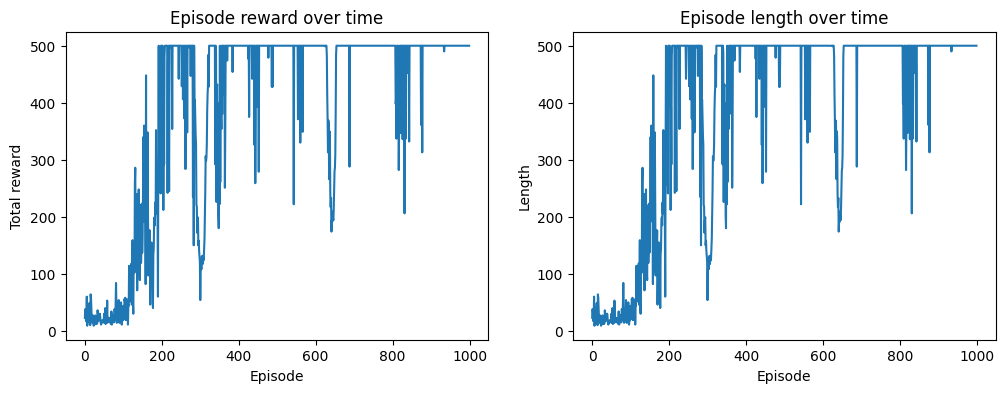

In [ ]:
env = create_env("CartPole-v1")
n_hidden = 64
lr = 0.001
net = Policy(env, n_hidden, lr=lr, optStep=.99)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode)

agent.train()
agent.log()

In [ ]:
display_video(750)

Available device: cpu - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

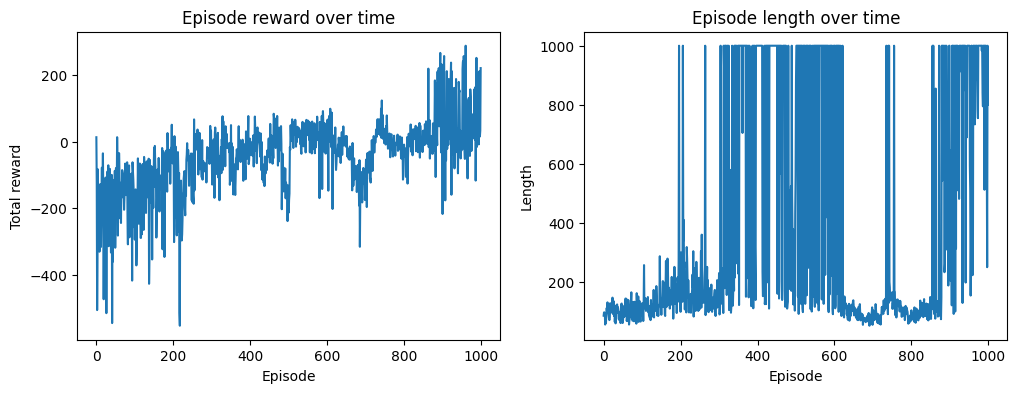

In [ ]:
env = create_env("LunarLander-v2")
n_hidden = 64
lr = 0.001
net = Policy(env, n_hidden, lr=lr, optStep=.99)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode)

agent.train()
agent.log()

In [ ]:
display_video(950)

## **Replay Buffer for experiance**

which is unnecessary

In [ ]:
class ReplayBuffer():
    """
    A fixed-size buffer that stores agent experiences for replay.

    Attributes:
        capacity (int): Maximum number of experiences the buffer can hold.
        buffer (deque): A double-ended queue to store experiences with a maximum length of `capacity`.
    """
    def __init__(self, capacity):
        """
        Initialize the ReplayBuffer.

        Args:
            capacity (int): The maximum number of experiences to store in the buffer.
        """
        self.capacity = capacity  # Maximum size of the buffer
        self.buffer = deque(maxlen=self.capacity)  # Create a deque with a fixed maximum size

    def __len__(self):
        """
        Return the current number of experiences stored in the buffer.

        Returns:
            int: Number of elements in the buffer.
        """
        return len(self.buffer)

    def append(self, experience):
        """
        Add a new experience to the buffer.

        If the buffer is full, the oldest experience is automatically removed.

        Args:
            experience (tuple): A single experience (state, action, reward, next_state, done).
        """
        self.buffer.append(experience)

    def sample(self, batch_size):
        """
        Sample a random batch of experiences from the buffer.

        Args:
            batch_size (int): The number of experiences to sample.

        Returns:
            list: A list of randomly sampled experiences from the buffer.
        """
        batch_size = min(batch_size, len(self.buffer))
        return random.sample(self.buffer, batch_size)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class REINFORCE_Buffer:
    """
    A REINFORCE agent with experience replay.

    The agent uses a replay buffer to improve sample efficiency and training stability.
    """

    def __init__(self, env, network, gamma, n_episode):
        """
        Initialize the REINFORCE agent with a replay buffer.

        Args:
            env: The environment (OpenAI Gym compatible).
            network: The neural network used for policy approximation and updates.
            gamma: Discount factor for future rewards.
            n_episode: Total number of episodes for training.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Environment and agent parameters
        self.env = env
        self.network = network  # Policy network
        self.n_action = env.action_space.n  # Number of possible actions
        self.gamma = gamma  # Discount factor for rewards
        self.n_episode = n_episode  # Total number of training episodes
        self.epi = 0  # Current episode index
        self.buffer = ReplayBuffer(5_000)  # Replay buffer to store experiences
        self.batch_size = 512  # Number of experiences sampled for training
        self.trajectory = []  # Stores state-action-reward trajectories
        self.best_score = -np.inf  # Track the best score achieved during training

        # Metrics to track training progress
        self.length_episode = [0] * n_episode  # Track the number of steps per episode
        self.total_reward_episode = [0] * n_episode  # Track the total reward per episode

    def train(self):
        """
        Train the REINFORCE agent using experiences from the replay buffer.
        """
        print(f"Available device: {self.device} - Highest possible score: {self.env.spec.reward_threshold}")
        pbar = tqdm(range(self.n_episode))  # Progress bar for episodes

        for episode in pbar:
            # Update progress bar with average reward over the last 50 episodes
            avg_reward = np.mean(self.total_reward_episode[max(0, episode - 50):episode + 1])
            pbar.set_description(f"α Neural network: {round(self.network.optimizer.param_groups[0]['lr'], 6)} |"
                                 f" Avg Reward: {avg_reward:.2f}")

            # Play one episode and collect trajectory data
            self.play(train=True)

            # Extract states, actions, and rewards from the trajectory
            states, actions, rewards = zip(*self.trajectory)

            # Convert states and actions to tensors
            states = torch.stack(states).to(self.device)
            actions = torch.tensor(actions).to(self.device)

            # Compute discounted returns and normalize them
            returns = torch.tensor(self.compute_discounted_returns(rewards), dtype=torch.float32)
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Update the policy network using the collected trajectory
            self.network.update(states, actions, returns)

            # Store the processed experience in the replay buffer
            self.buffer.append((states, actions, returns))

            # Use the replay buffer to sample additional experiences for training
            if self.epi % 5 == 0 and self.epi < 100 and avg_reward < 0.2 * self.env.spec.reward_threshold:
                states, actions, returns = zip(*self.buffer.sample(self.batch_size))
                self.network.update(states[0], actions[0], returns[0])

    def compute_discounted_returns(self, rewards):
        """
        Compute discounted returns for a single trajectory.

        Args:
            rewards (list): Rewards obtained during the trajectory.

        Returns:
            list: Discounted returns for each time step.
        """
        returns = []
        G = 0  # Initialize the cumulative return
        for r in reversed(rewards):
            G = r + self.gamma * G  # Compute the discounted return
            returns.insert(0, G)  # Insert at the beginning to reverse the order
        return returns

    def play(self, train=False):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, track episode statistics and store experiences.
        """
        # Reset the environment and get the initial state
        state = self.env.reset()
        state = torch.tensor(state, device=self.device)  # Convert state to tensor
        done = False  # Indicates if the episode is over
        self.trajectory = []  # Clear the trajectory for the new episode

        while not done:
            # Predict action probabilities using the policy network
            probs = self.network.predict(state)

            # Sample an action based on the probabilities
            action = torch.multinomial(probs, 1).item()

            # Take the action in the environment and observe the outcome
            next_state, reward, done, _ = self.env.step(action)

            if train:
                # Update episode statistics
                self.length_episode[self.epi] += 1
                self.total_reward_episode[self.epi] += reward

            # Convert the next state to a tensor
            next_state = torch.tensor(next_state, device=self.device)

            # Store the experience (state, action, reward) in the trajectory
            self.trajectory.append((state, action, reward))

            # Update the current state
            state = next_state

        if train:
            # Increment the episode counter and adjust the learning rate schedule
            self.epi += 1
            self.network.schedul.step()

    def log(self):
        """
        Plot and log the rewards and lengths of episodes over time.
        """
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

Available device: cpu - Highest possible score: 475.0


  0%|          | 0/1000 [00:00<?, ?it/s]

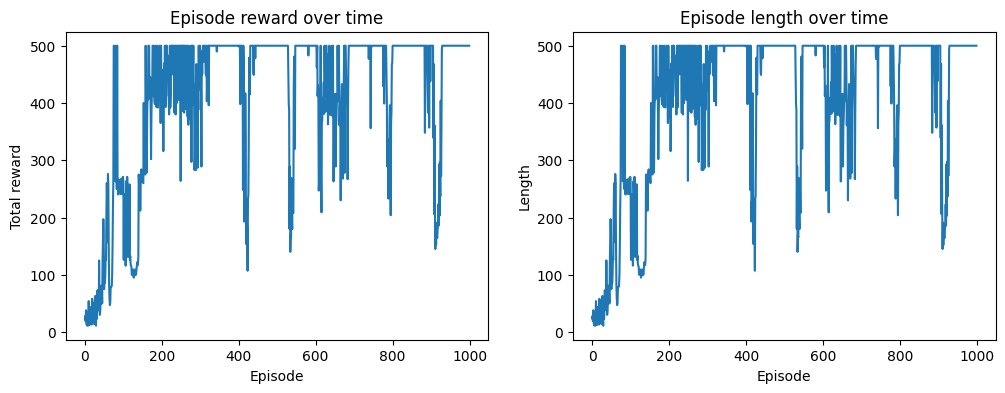

In [ ]:
env = create_env("CartPole-v1")
n_hidden = 64
lr = 0.001
net = Policy(env, n_hidden, lr=lr, optStep=.99)

gamma = 0.99
n_episode = 1000
agent = REINFORCE_Buffer(env, net, gamma, n_episode)

agent.train()
agent.log()

Available device: cpu - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

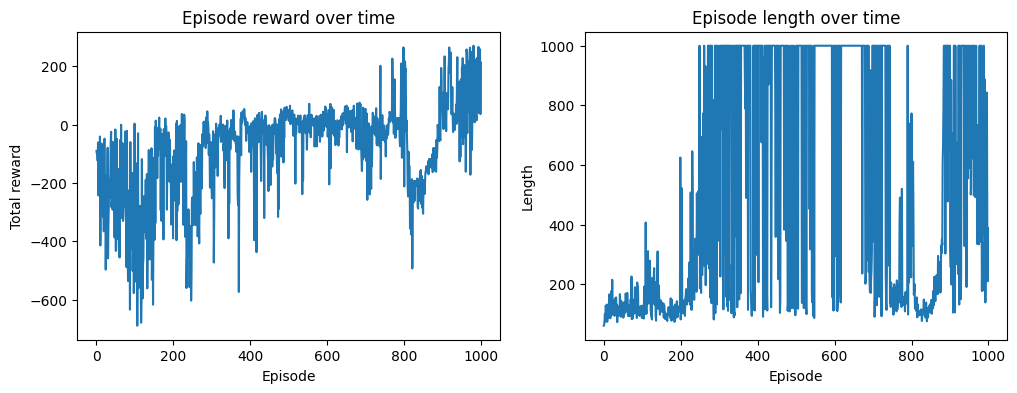

In [ ]:
env = create_env("LunarLander-v2")
n_hidden = 64
lr = 0.001
net = Policy(env, n_hidden, lr=lr, optStep=.99)

gamma = 0.99
n_episode = 1000
agent = REINFORCE_Buffer(env, net, gamma, n_episode)

agent.train()
agent.log()

In [ ]:
display_video(950)

## **Actor-Critic**

$$
\large \nabla_\theta J(\theta) = \large  \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[\nabla_\theta \log(p_\theta(\tau)) r(\tau) \right]
$$

In above formula the probability of each trajectories is being increased by some different amount base on their return reward.

Reducing the rewards with a baseline reduces the variance of the update. The introduction of a baseline does not alter the expected value of the gradient update.

$$
\large \nabla_\theta J(\theta) =  \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[ \Biggl(\sum^{T}_{t=1} \nabla_\theta \log\pi_\theta(a_t|s_t) \Biggr) \Biggl( r(\tau) - b(s_t) \Biggr) \right]
$$

<br>

---
- we want to show that it doesn't change the optimal gradient, gradient over second part, which is $b(s_t)$:

$$
\begin{split}
\nabla_\theta J(\theta) & =  \mathbb{E}_{\tau \sim p_\theta(\tau)} \left[ \Biggl(\sum^{T}_{t=1} \nabla_\theta \log\pi_\theta(a_t|s_t) \Biggr)b(s_t) \right]\\
\\
\tau \sim p_\theta(\tau) \rightarrow a_t \sim \pi_\theta(a_t|s_t)\\
\text{action depends on probability distribution}\\
\\
& = \sum^{T}_{t=1}  \mathbb{E}_{a_t \sim \pi_\theta(a_t|s_t)} \left[ \Biggl( \nabla_\theta \log\pi_\theta(a_t|s_t) \Biggr)b(s_t) \right]\\
\\
& = \int \pi_\theta(a_t|s_t) \Bigl( \nabla_\theta \log\pi_\theta(a_t|s_t) \Bigr)b(s_t)da_t\\
\\
& = \int \pi_\theta(a_t|s_t)  \frac{\nabla_\theta \pi_\theta(a_t|s_t)}{\pi_\theta(a_t|s_t)} b(s_t)da_t\\
\\
& = \int \nabla_\theta \pi_\theta(a_t|s_t)b(s_t)da_t\\
\\
& = b(s_t) \nabla_\theta \int \pi_\theta(a_t|s_t)da_t\\
\text{integral will evaluate to 1}\\
& = b(s_t) * \nabla_\theta(1) = b(s_t) * 0 = 0
\end{split}
$$

<br>

---

<br>

$$
\large L(\theta) =  \large -\frac{1}{N} \sum^{N}_{i=1} \sum^{T}_{t=1} log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \Bigl( G(s_t) - b^i(s_t) \Bigr)
$$

> $G(s_t) = \sum^{T}_{t'=t} \gamma^{t'-t} r \Bigl(s^i_{t'}, a^i_{t'} \Bigr)$

<br>

$$
\large L(\theta) =  \large -\frac{1}{N} \sum^{N}_{i=1}  \left[\Biggl(\sum^{T}_{t=1} log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \Bigl( G(s_t) - b^i(s_t) \Bigr) \Biggr) - \beta \sum_{a_i} \pi_\theta(a^i_t|s^i_t).log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \right]
$$

<br>

### **Until now we were introducing base line variance reduction**

<br>

> Instead of $G(s_t)$ we will use $Q(s^i_t, a^i_t)$

$$
\large Q(s^i_t, a^i_t) - b^i(s) = Q(s^i_t, a^i_t) - V(s_t)
$$

<br>

now we are using $V(s_{t+1})$ as base line. The right side known as *Advantage*:

<br>

$$
\large A(s^i_t, a^i_t) = Q(s^i_t, a^i_t) - V(s_t) = r(s^i_t, a^i_t) + V(s_{t+1}) - V(s_t)
$$

> In TD(0): $Q(s^i_t, a^i_t) = r(s^i_t, a^i_t) + V(s_{t+1})$

$$
\large L(\theta) =  \large -\frac{1}{N} \sum^{N}_{i=1} \sum^{T}_{t=1} log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \Biggl( A^i(s_t, a_t) \Biggr)
$$

<br>

- Actor: $Q$ is the value of following a specific step $a_t$ using the current policy.
- Critic: $V$ are the average values of the following curent policy.

The actor is trying to maximize the reward, and the critic is telling the algorithm how good or bad that specific step was as compared to the average.

<br>

---
- Using the MC approach we will get this:

$$
\large L(\theta) =  \large -\frac{1}{N} \sum^{N}_{i=1} \sum^{T}_{t=1} log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \Biggl( \sum^{T}_{t'=t}r(s^i_t, a^i_t) \Biggr)
$$


<br>

- Using the TD approach we will get this:

$$
\large L(\theta) =  \large -\frac{1}{N} \sum^{N}_{i=1} \sum^{T}_{t=1} log\pi_\theta \Bigl(a^i_t|s^i_t \Bigr) \Biggl( r(s^i_t, a^i_t) + V(s_{t+1}) - V(s_t) \Biggr)
$$

---

<br>

In [ ]:
class DeepNetwork(nn.Module):
    """
    A deep neural network for approximating Q-values.
    """

    def __init__(self, n_state, n_action, n_hidden=64):
        """
        Initialize the network.

        Args:
            n_state (int): Dimension of the state space.
            n_action (int): Number of possible actions.
            n_hidden (int): Number of hidden units in the layers.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_action)
        )

    def forward(self, state):
        """
        Forward pass through the network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Output Q-values for each action.
        """
        return self.model(state)


class ValueNetwork(nn.Module):
    """
    A deep neural network for approximating Q-values.
    """

    def __init__(self, n_state, n_hidden=64):
        """
        Initialize the network.

        Args:
            n_state (int): Dimension of the state space.
            n_action (int): Number of possible actions.
            n_hidden (int): Number of hidden units in the layers.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, state):
        """
        Forward pass through the network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Output Q-values for each action.
        """
        return self.model(state)



class Policy():
    """
    Deep Q-Network (DQN) implementation.
    """

    def __init__(self, env, n_hidden=50, lr=0.05, optStep=0.9):
        """
        Initialize the DQN agent.

        Args:
            env: OpenAI Gym environment.
            n_hidden (int): Number of hidden units in the neural network.
            lr (float): Learning rate for the optimizer.
            optStep (float): Step size factor for learning rate scheduler.
        """
        self.n_action = env.action_space.n  # Number of possible actions
        self.n_state = env.observation_space.shape[0]  # Dimension of state space
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Initialize the primary and target networks
        self.model = DeepNetwork(self.n_state, self.n_action, n_hidden).to(self.device)
        self.value_model = ValueNetwork(self.n_state, n_hidden).to(self.device)

        # Set up the optimizer and learning rate scheduler
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.schedul = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=optStep)

        self.base_optimizer = torch.optim.Adam(self.value_model.parameters(), lr)
        self.base_schedul = torch.optim.lr_scheduler.StepLR(self.base_optimizer, step_size=50, gamma=optStep)

    def predict(self, state):
        """
        Predict Q-values for the given state using the primary network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Predicted Q-values.
        """
        with torch.no_grad():
            logits = self.model(state)
            return nn.functional.softmax(logits, -1)

    def compute_advantage(self, states, returns):
        """
        Compute the advantage using the baseline (value network).

        Args:
            states (Tensor): Batch of states.
            returns (Tensor): Batch of discounted returns.

        Returns:
            Tensor: Advantage for each state-action pair.
        """
        with torch.no_grad():
            baseline = self.value_model(states).squeeze()  # Predicted value
        advantage = returns - baseline
        return advantage

    def cross_entropy(self, probs, log_probs, log_probs_for_actions, advantage, entropy_coef=0.001):
        """
        Compute the weighted L1 loss.

        Args:
            predictions (Tensor): Predicted Q-values.
            targets (Tensor): Target Q-values.
            weights (Tensor): Importance-sampling weights.

        Returns:
            Tensor: Weighted L1 loss.
        """
        J = torch.mean(log_probs_for_actions * advantage) # policy_loss
        H = -(probs * log_probs).sum(-1).mean() # entropy_loss

        return -(J + entropy_coef * H)


    def update(self, states, actions, returns):
        """
        Update the primary network using a batch of experiences.

        Args:
            states (Tensor): Batch of states.
            actions (Tensor): Batch of actions taken.
            q_value (Tensor): Target Q-values.
            weights (Tensor): Importance-sampling weights.
        """
        # --- Update Policy Network ---
        logits = self.model(states)
        probs = nn.functional.softmax(logits, -1)
        log_probs = nn.functional.log_softmax(logits, -1)
        log_probs_for_actions = log_probs[range(len(actions)), actions]

        # Compute advantage
        advantage = self.compute_advantage(states, returns)
        # Compute policy loss
        loss = self.cross_entropy(probs, log_probs, log_probs_for_actions, advantage)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # --- Update Value Network ---
        baseline = self.value_model(states).squeeze()  # Predicted baseline
        base_loss = nn.functional.mse_loss(baseline, returns)  # MSE loss
        self.base_optimizer.zero_grad()
        base_loss.backward()
        self.base_optimizer.step()


Available device: cpu - Highest possible score: 475.0


  0%|          | 0/1000 [00:00<?, ?it/s]

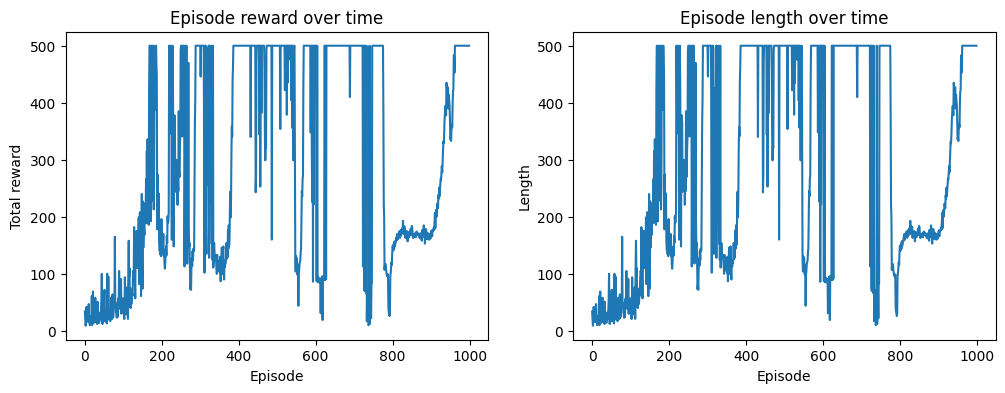

In [ ]:
env = create_env("CartPole-v1")
n_hidden = 64
lr = 0.001
net = Policy(env, n_hidden, lr=lr, optStep=.99)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode)

agent.train()
agent.log()

Available device: cpu - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

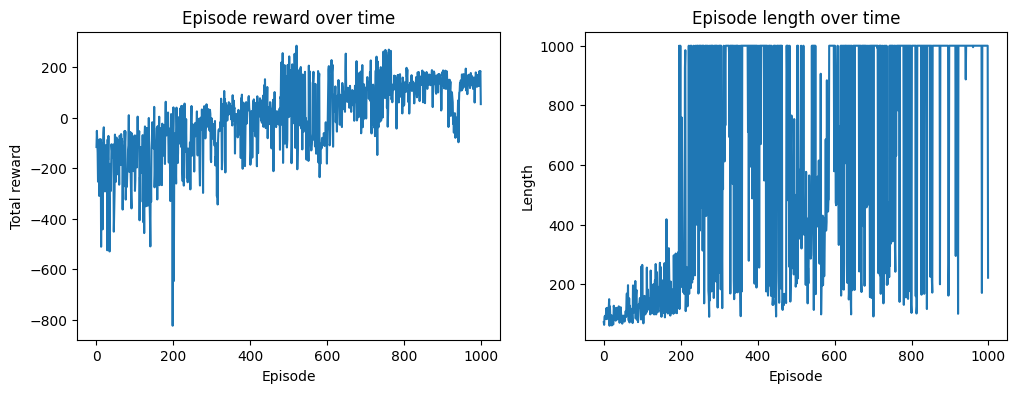

In [ ]:
env = create_env("LunarLander-v2")
n_hidden = 64
lr = 0.001
net = Policy(env, n_hidden, lr=lr, optStep=.99)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode)

agent.train()
agent.log()

In [ ]:
display_video(950)

## **Continuous environment**

$$
\large \pi\left(a|s;\theta\right) \sim N\left( \mu, \sigma^2 \right)
$$

Let’s say for state $s^i_t$ the mean that the model produces is $\mu_\theta(s^i_t)$ (Neural network output is $\mu$). The value of $\log\pi_\theta(a^i_t, s^i_t)$ is then given by the following:

<br>

$$
\begin{split}
\large \pi_\theta(a^i_t, s^i_t) & = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{\left( -\frac{1}{2 \sigma^2}(a^i_t - \mu_\theta)^2 \right)} \\
\\
\large \log \bigl( \pi_\theta(a^i_t, s^i_t) \bigr) & = \large \log \Biggl( \frac{1}{\sqrt{2 \pi \sigma^2}} e^{\left( -\frac{1}{2 \sigma^2}(a^i_t - \mu_\theta)^2 \right)} \Biggr) \\
\\
& = \large \log1 - \log \sqrt{2 \pi \sigma^2} + \log e^{\left( -\frac{1}{2 \sigma^2}(a^i_t - \mu_\theta)^2 \right)} \\
\\
& = \large - \frac{1}{2} \log2\pi - \log\sigma -\frac{1}{2 \sigma^2}(a^i_t - \mu_\theta)^2 \\
\\
→ \large \nabla_\theta \log \bigl( \pi_\theta(a^i_t, s^i_t) \bigr) & = \large const * (a^i_t - \mu_\theta) \nabla_\theta \mu_\theta(s^i_t)
\end{split}
$$

<br>

---
- How we get this derivative:

$$
\begin{split}
\large \nabla_\theta \log \bigl( \pi_\theta(a^i_t, s^i_t) \bigr) & = \large \nabla_\theta \Biggl(\large - \frac{1}{2} \log2\pi - \log\sigma -\frac{1}{2 \sigma^2}(a^i_t - \mu_\theta)^2 \Biggr) \\
\\
& = \large 0 + 0 - 2 * \frac{1}{2 \sigma^2}(a^i_t - \mu_\theta)\nabla_\theta(-\mu_\theta)\\
& = \large \frac{1}{\sigma^2}(a^i_t - \mu_\theta)\nabla_\theta(\mu_\theta)
\end{split}
$$

---

We need to weight the mean square error with the trajectory return:

$$
\begin{split}
\large L_{\textit{MSE}}(\theta) & =  \large \frac{1}{N} \sum^{N}_{i=1}  \left[ \Biggl(\sum^{T}_{t=1} (a^i_t - \mu_\theta)^2 \Biggr) \Biggl( \sum^{T}_{t=1} r \Bigl(s^i_t, a^i_t \Bigr) \Biggr) \right] \\
\\
\textit{If we using gradient:} \\
\\
\large - \nabla_\theta L_{\textit{MSE}}(\theta) & =  \large \frac{1}{N} \sum^{N}_{i=1}  \left[ \Biggl(\sum^{T}_{t=1} (a^i_t - \mu_\theta) \nabla_\theta \mu_\theta(s^i_t) \Biggr) \Biggl( \sum^{T}_{t=1} r \Bigl(s^i_t, a^i_t \Bigr) \Biggr) \right] \\
\end{split}
$$

### **Adding Variance Reduction with Discounted Rewards**

To reduce variance:
Use discounted cumulative rewards $G_t$ instead of plain rewards:
$$
\large G_t = \sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}, a_{t'})
$$

Subtract a baseline $b(s_t)$ , such as the mean reward or a value function $V(s_t)$, to reduce variance:
$$
A_t = G_t - b(s_t)
$$
> $A_t$ is the advantage function, which measures how good the action was compared to the baseline.

Modify the formula by replacing $r(s_{it}, a_{it})$ with the discounted advantage  $A_t$ :

$$
\large A_t = \left( \sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}, a_{t'}) \right) - b(s_t)
$$

<br>

Modified Formula (With Variance Reduction)

$$
\begin{split}
\large L_{\textit{MSE}}(\theta) & =  \large \frac{1}{N} \sum^{N}_{i=1}  \left[ \Biggl(\sum^{T}_{t=1} (a^i_t - \mu_\theta)^2 \Biggr) \Biggl( \sum_{t=1}^{T} A_t \Biggr) \right] \\
\\
\textit{If we using gradient:} \\
\\
\large -\nabla_\theta L_{MSE}(\theta) & = \large \frac{1}{N} \sum_{i=1}^{N} \left[ \left( \sum_{t=1}^{T} (a^i_t - \mu_\theta) \nabla_\theta \mu_\theta(s^i_t) \right) \left( \sum_{t=1}^{T} A_t \right) \right] \\
\end{split}
$$


In [ ]:
from torch.distributions import Normal

class PolicyNetwork(nn.Module):
    """
    A deep neural network for approximating Q-values.
    """

    def __init__(self, n_state, action_dim, n_hidden=64):
        """
        Initialize the network.

        Args:
            n_state (int): Dimension of the state space.
            n_action (int): Number of possible actions.
            n_hidden (int): Number of hidden units in the layers.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        """
        Forward pass through the network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Output Q-values for each action.
        """
        return self.model(state), self.log_std


class ValueNetwork(nn.Module):
    """
    A deep neural network for approximating Q-values.
    """

    def __init__(self, n_state, n_hidden=64):
        """
        Initialize the network.

        Args:
            n_state (int): Dimension of the state space.
            n_action (int): Number of possible actions.
            n_hidden (int): Number of hidden units in the layers.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, state):
        """
        Forward pass through the network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Output Q-values for each action.
        """
        return self.model(state)

In [ ]:
class REINFORCE():
    """
    A policy gradient agent implementing the REINFORCE algorithm.

    The agent learns to maximize the expected return using policy gradient updates.
    """

    def __init__(self, env, network, gamma, n_episode):
        """
        Initialize the REINFORCE agent.

        Args:
            env: The environment (OpenAI Gym compatible).
            network: The neural network used for policy approximation and updates.
            gamma: Discount factor for future rewards.
            n_episode: Total number of episodes for training.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Environment and agent parameters
        self.env = env
        self.network = network  # Policy network
        self.gamma = gamma  # Discount factor for rewards
        self.n_episode = n_episode  # Total number of training episodes
        self.epi = 0  # Current episode index
        self.trajectory = []  # Stores state-action-reward trajectories

        # Metrics to track training progress
        self.length_episode = [0] * n_episode  # Track number of steps per episode
        self.total_reward_episode = [0] * n_episode  # Track total rewards per episode

    def train(self):
        """
        Train the agent using the REINFORCE algorithm.
        """
        print(f"Available device: {self.device} - Highest possible score: {self.env.spec.reward_threshold}")
        pbar = tqdm(range(self.n_episode))  # Progress bar for training episodes

        for episode in pbar:
            # Play one episode and collect trajectory data
            self.play(train=True)

            # Extract states, actions, and rewards from the trajectory
            states, actions, rewards = zip(*self.trajectory)

            # Convert states and actions to tensors
            states = torch.stack(states).to(self.device)  # Batch of states
            actions = torch.tensor(actions).to(self.device)  # Actions taken

            # Compute discounted returns and normalize them
            returns = torch.tensor(self.compute_discounted_returns(rewards), dtype=torch.float32)
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # Normalize returns for stability

            # Update the policy network using the collected trajectory
            self.network.update(states, actions, returns)

            # Update the progress bar with learning rate and recent average rewards
            avg_reward = np.mean(self.total_reward_episode[max(0, episode - 50):episode + 1])
            pbar.set_description(f"α Neural network: {round(self.network.optimizer.param_groups[0]['lr'], 6)} |"
                                 f" Avg Reward: {avg_reward:.2f}")

    def compute_discounted_returns(self, rewards):
        """
        Compute discounted returns for a single trajectory.

        Args:
            rewards (list): Rewards obtained during the trajectory.

        Returns:
            list: Discounted returns for each time step.
        """
        returns = []
        G = 0  # Initialize the discounted return
        for r in reversed(rewards):
            G = r + self.gamma * G  # Compute the discounted return
            returns.insert(0, G)  # Insert at the beginning to reverse the order
        return returns

    def play(self, train=False):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, track episode statistics and update the learning schedule.
        """
        # Reset the environment and get the initial state
        state = self.env.reset()
        state = torch.tensor(state, device=self.device)  # Convert state to tensor
        done = False  # Indicates if the episode is over
        self.trajectory = []  # Clear the trajectory for the new episode

        while not done:

            dist = self.network.predict(state)
            action = dist.sample().cpu().numpy()
            # Take the action in the environment and observe the outcome
            next_state, reward, done, _ = self.env.step(action)

            if train:
                # Update episode statistics
                self.length_episode[self.epi] += 1
                self.total_reward_episode[self.epi] += reward

            # Convert the next state to a tensor
            next_state = torch.tensor(next_state, device=self.device)

            # Store the experience (state, action, reward) in the trajectory
            self.trajectory.append((state, action, reward))

            # Update the current state
            state = next_state

        if train:
            # Increment the episode counter and adjust the learning rate schedule
            self.epi += 1
            self.network.schedul.step()

    def log(self):
        """
        Plot and log the rewards and lengths of episodes over time.
        """
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

In [ ]:
class Policy():
    """
    Deep Q-Network (DQN) implementation.
    """

    def __init__(self, env, n_hidden=50, lr=0.05, optStep=0.9):
        """
        Initialize the DQN agent.

        Args:
            env: OpenAI Gym environment.
            n_hidden (int): Number of hidden units in the neural network.
            lr (float): Learning rate for the optimizer.
            optStep (float): Step size factor for learning rate scheduler.
        """
        self.action_dim = env.action_space.shape[0] # Number of possible actions
        self.n_state = env.observation_space.shape[0]  # Dimension of state space
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Initialize the primary and target networks
        self.policy_model = PolicyNetwork(self.n_state, self.action_dim, n_hidden).to(self.device)
        self.value_model = ValueNetwork(self.n_state, n_hidden).to(self.device)

        # Set up the optimizer and learning rate scheduler
        self.optimizer = torch.optim.Adam(self.policy_model.parameters(), lr)
        self.schedul = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=optStep)

        self.base_optimizer = torch.optim.Adam(self.value_model.parameters(), lr)
        self.base_schedul = torch.optim.lr_scheduler.StepLR(self.base_optimizer, step_size=50, gamma=optStep)

    def predict(self, state):
        """
        Predict Q-values for the given state using the primary network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Predicted Q-values.
        """
        with torch.no_grad():
            mu, log_std = self.policy_model(state)  # Mean output from the network
            # log_std = torch.clamp(log_std, min=-20, max=2)
            sigma = torch.exp(log_std) + 1e-6  # Convert to standard deviation and Ensure sigma is not zero
            return Normal(mu, sigma)

    def compute_advantage(self, states, returns):
        """
        Compute the advantage using the baseline (value network).

        Args:
            states (Tensor): Batch of states.
            returns (Tensor): Batch of discounted returns.

        Returns:
            Tensor: Advantage for each state-action pair.
        """
        with torch.no_grad():
            value = self.value_model(states).squeeze()  # Predicted value
        advantage = returns - value
        return advantage

    def MSE(self, mu, actions, advantages):

        sum_squared_error = ((actions - mu) ** 2).sum(dim=1)

        return (sum_squared_error * advantages).mean()


    def update(self, states, actions, returns):
        """
        Update the primary network using a batch of experiences.

        Args:
            states (Tensor): Batch of states.
            actions (Tensor): Batch of actions taken.
            q_value (Tensor): Target Q-values.
            weights (Tensor): Importance-sampling weights.
        """
        mu, log_std = self.policy_model(states)  # Mean output from the network
        # log_std = torch.clamp(log_std, min=-20, max=2)
        sigma = torch.exp(log_std) + 1e-6  # Convert to standard deviation and Ensure sigma is not zero

        dist = Normal(mu, sigma)
        action = dist.sample()  # Sample action from the Gaussian
        log_prob = dist.log_prob(action).sum(dim=-1)  # Log-prob of the action


        # Compute advantage
        advantages = self.compute_advantage(states, returns)


        loss = self.MSE(mu, actions, advantages)
        # loss = - torch.mean(log_prob * advantages)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # --- Update Value Network ---
        value = self.value_model(states).squeeze()  # Predicted baseline
        base_loss = nn.functional.mse_loss(value, returns)  # MSE loss
        self.base_optimizer.zero_grad()
        base_loss.backward()
        self.base_optimizer.step()

Available device: cpu - Highest possible score: 200


α Neural network: 0.000358 | Avg Reward: 128.30: 100%|██████████| 1000/1000 [27:05<00:00,  1.63s/it]


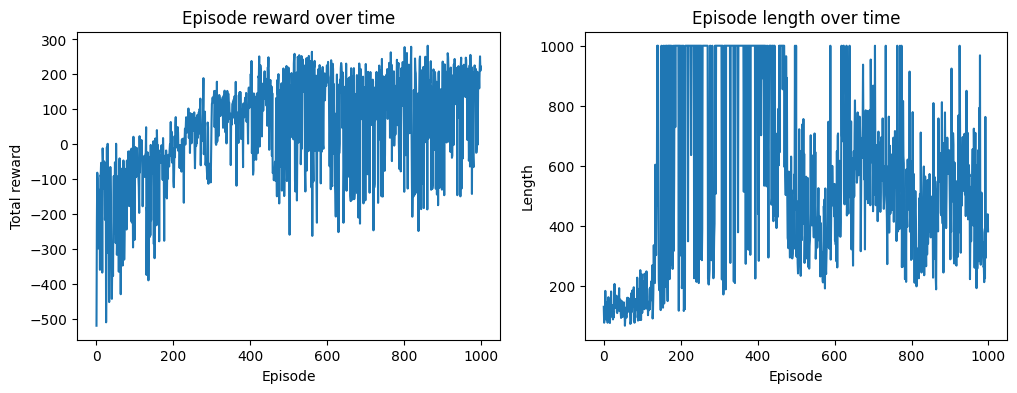

In [ ]:
env = create_env('LunarLanderContinuous-v2')
n_hidden = 64
lr = 0.001
net = Policy(env, n_hidden, lr=lr, optStep=.95)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode)

agent.train()
agent.log()

In [ ]:
display_video(950)

In [ ]:
env = create_env("MountainCarContinuous-v0")
n_hidden = 64
lr = 0.001
net = Policy(env, n_hidden, lr=lr, optStep=.99)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode)

agent.train()
agent.log()

Available device: cpu - Highest possible score: 90.0


α Neural network: 0.00097 | Avg Reward: -100.22:  17%|█▋        | 173/1000 [02:15<10:49,  1.27it/s]


KeyboardInterrupt: 

In [ ]:
env = create_env("MountainCarContinuous-v0")
n_hidden = 64
lr = 0.005
net = Policy(env, n_hidden, lr=lr, optStep=.9)

gamma = 0.99
n_episode = 1000
agent = REINFORCE(env, net, gamma, n_episode)

agent.train()
agent.log()

Available device: cpu - Highest possible score: 90.0


α Neural network: 0.003281 | Avg Reward: -96.46:  20%|██        | 200/1000 [02:32<09:25,  1.41it/s]